> gohu111 — Иконников Григорий, РИ-400034

---



> Для анализа был выбран временной ряд **online_retail.csv**



In [86]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

## Чтение из файла online_retail.csv

In [87]:
retail = pd.read_csv('online_retail.csv', index_col = ['date'], parse_dates = ['date'])

In [88]:
retail.head(6)

,total sales
date,
2009-12-01,3106.000000
2009-12-02,3254.000000
2009-12-03,2951.000000
2009-12-04,2529.000000
2009-12-05,2644.541758
2009-12-06,1911.000000


## Визуализация ряда

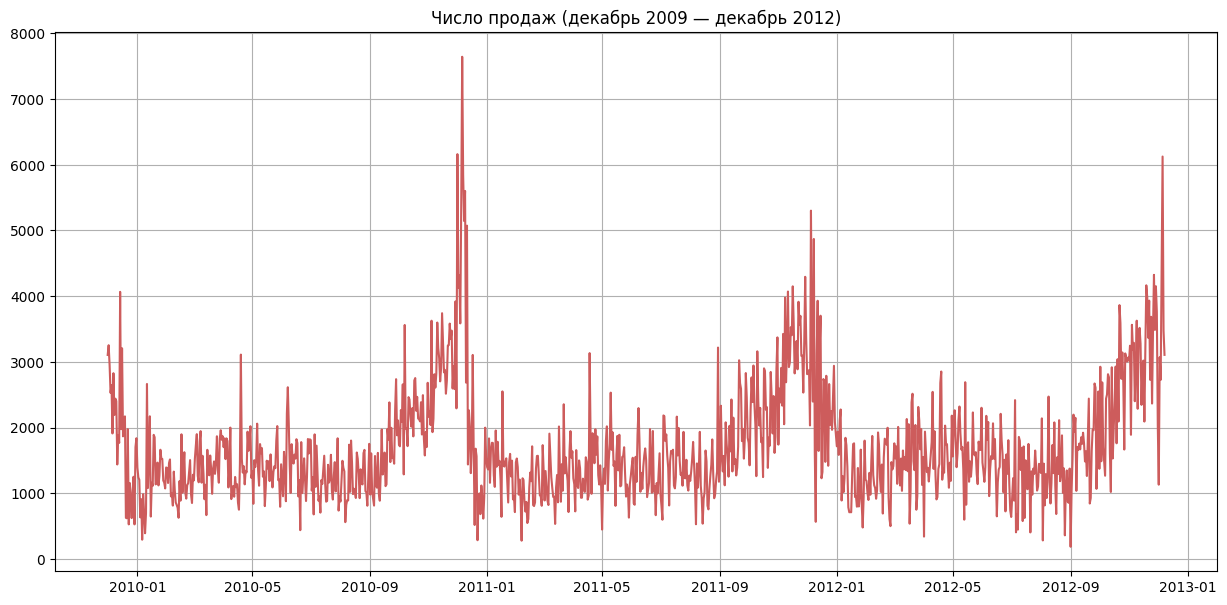

In [89]:
plt.figure(figsize = (15, 7))
plt.plot(retail, color = 'indianred')
plt.title('Число продаж (декабрь 2009 — декабрь 2012)')
plt.grid(True)
plt.show()

> На графике наблюдается **сезонность**: за годичный период увеличение продаж в период с сентября по декабрь, затем резкое уменьшение с декабря по январь. Также есть небольшие приросты в период с апреля по май.

> Нет чётко выраженного **тренда**, поскольку продажи колеблются относительно друг друга в одинаковые месяцы, в том числе максимальное годовое значение.

> Сезонность говорит о том, что временной ряд **нестационарный**.

## Тренировочная и тестовая выборки

In [90]:
prediction_size = int(len(retail) * 0.15)
# Взял 15% данных в качестве тренировочной выборки

train_split = retail.iloc[:-prediction_size]
test_split = retail.iloc[-prediction_size:]

> Проверяю, что выборки не пересекаются

In [91]:
train_split.tail(2)

,total sales
date,
2012-06-25,724.879324
2012-06-26,1591.991887


In [92]:
test_split.head(2)

,total sales
date,
2012-06-27,1297.034564
2012-06-28,1808.301585


# **Бейзлайн**

In [93]:
def plotMovingAverage(series, window, plot_intervals=False, scale = 1.96,\
                      plot_anomalies = False):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window = window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Скользящее среднее\n размер окна = {}".format(window))
    plt.plot(rolling_mean, "g", label = "Тренд скользящего среднего", \
             color = 'blue')

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", \
                 label = "Верхний интервал / Нижний интервал", color = 'salmon')
        plt.plot(lower_bond, "r--", color = 'salmon')

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, \
                                     columns = series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10, color = 'red')

    plt.plot(series[window:], label = "Продажи", color = 'violet')
    plt.legend(loc = "upper left")
    plt.grid(True)

> Произвёл сглаживание с окном 7 — недельный тренд.

> Также подключил доверительные интервалы и детекцию аномалий

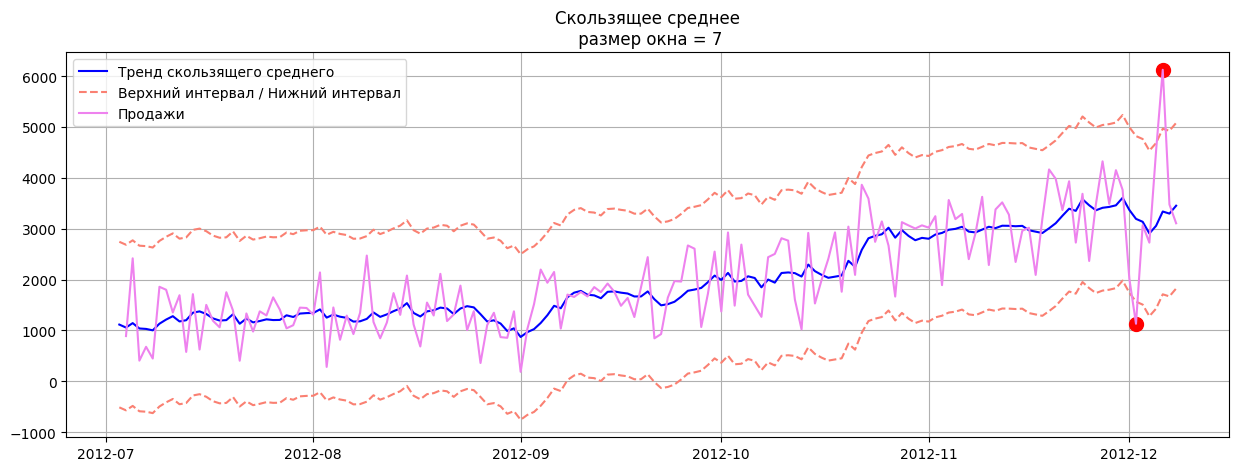

In [94]:
plotMovingAverage(test_split, 7, plot_intervals=True, plot_anomalies=True)

> Резкое падение продаж перед резким скачком — это признак какого-то события. Например, ожидание покупателями опредённого товара или скидки на товар.

## Экспоненциальное сглаживание

> Для сравнения взял метрику экспоненциального сглаживания

In [95]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [96]:
def plotExponentialSmoothing(series, alpha):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 5))
        plt.plot(exponential_smoothing(series, alpha), \
                     label="Альфа {}".format(alpha))
        plt.plot(series.values, "c", label = "Продажи", color = 'violet')
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Экспоненциальное сглаживание")
        plt.grid(True);

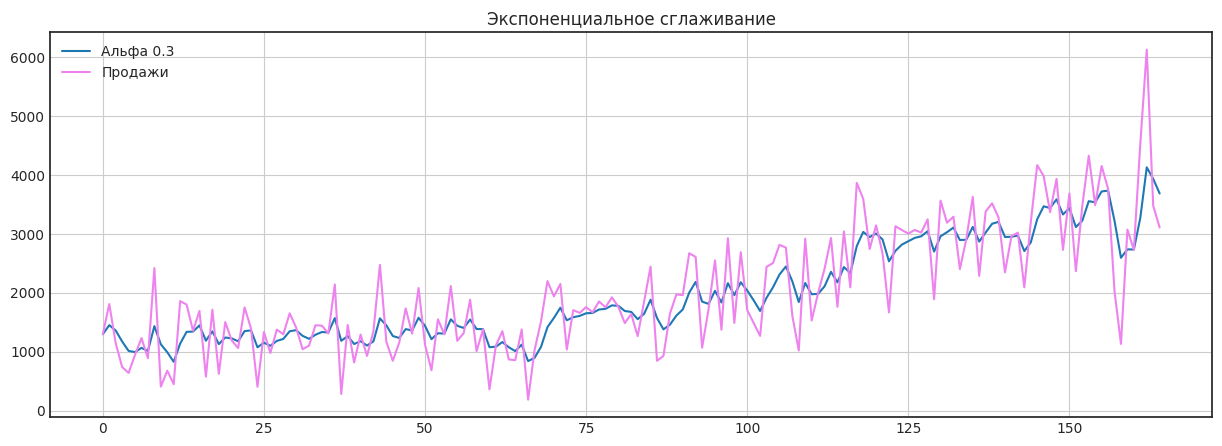

In [97]:
plotExponentialSmoothing(test_split['total sales'], 0.3)

>Бейзлайн отражает общее изменение данных за взятый период, когда экспоненциальное сглаживание сохраняет секции роста и падения продаж в более узких промежутках времени.

# **Статистическая модель**

##Тест Дики-Фуллера

In [98]:
def plotProcess(x):

    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 3))
        plt.plot(x, color = 'indianred')
        plt.title("Dickey-Fuller p-value: {}".format(round(sm.tsa.stattools.adfuller(x)[1], 4)))

>Здесь беру "тренировочную" выборку, чтобы оценивать пики в периоды декабря-января

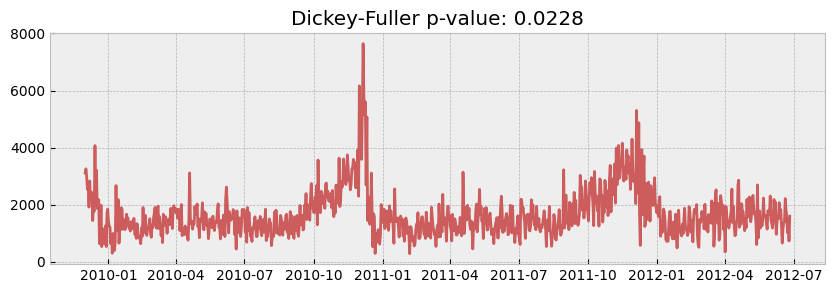

In [99]:
plotProcess(train_split['total sales'])

>**Вывод**:

>P-значение низкое (< 0.05) — нулевая гипотеза отвергается. Ряд можно считать стационарным.


## ACF / PACF

In [100]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))


        smt.graphics.plot_acf(y, lags = lags, ax=acf_ax, color = 'indianred')
        smt.graphics.plot_pacf(y, lags = lags, ax=pacf_ax, color = 'indianred')
        plt.tight_layout()

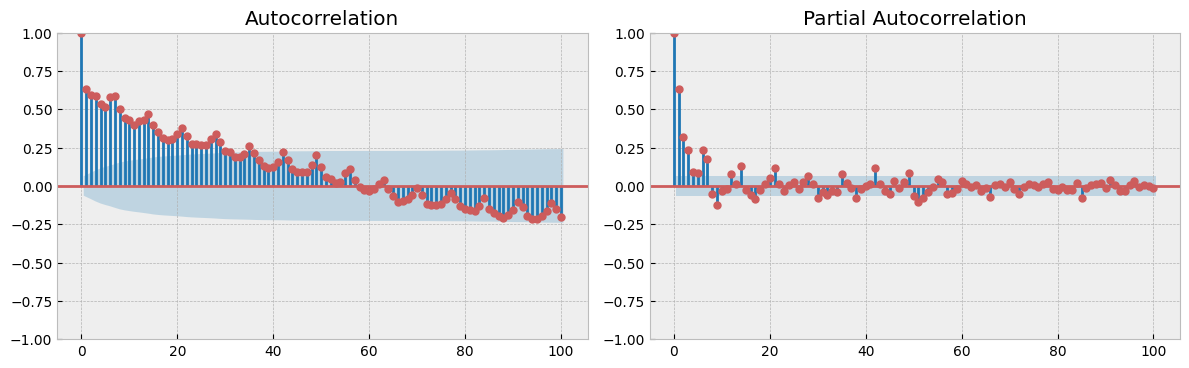

In [101]:
tsplot(train_split['total sales'], lags=100)

> График автокорреляции показывает своеобразные "дуги" продаж: примерно на каждыом 7-м лаге значения коррелируют с исходным лагом, что напоминает сезонность. При этом коэффициенты стремятся к области доверительного интервала и остаются в нём (при лагах > 200) — это говорит о слабости автокорреляции.

> График частичной автокорреляции показывает другие "дуги", где коэффициенты выходят из доверительного интервала с периодичностью в 8-9 лагов, но затем приближаются к нулю. Это также говорит о сезонности в коротких промежутках времени.

## Придание ряду стационарности — Дифференцирование

> Попробовал удалить "недельные" лаги.

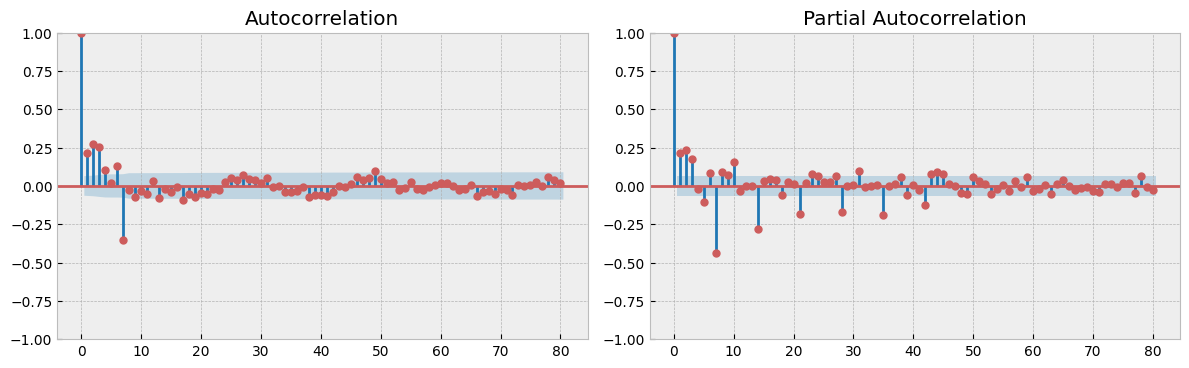

In [102]:
retail_diff = train_split['total sales'] - train_split['total sales'].shift(7)
tsplot(retail_diff[7:], lags=80)

> Некоторая сезонность ещё наблюдается, но значения коэффициентов приближаются к нулю. Также обнаружились заметные лаги (на графике PACF — каждый 7-й лаг до 42-го).

> Методы обычного дифференцирования не дали результатов, поэтому здесь не приведены

## Повторный тест Дики-Фуллера

In [103]:
def tsplot_new(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax = acf_ax, color = 'indianred')
        smt.graphics.plot_pacf(y, lags=lags, ax = pacf_ax, color = 'indianred')
        plt.tight_layout()

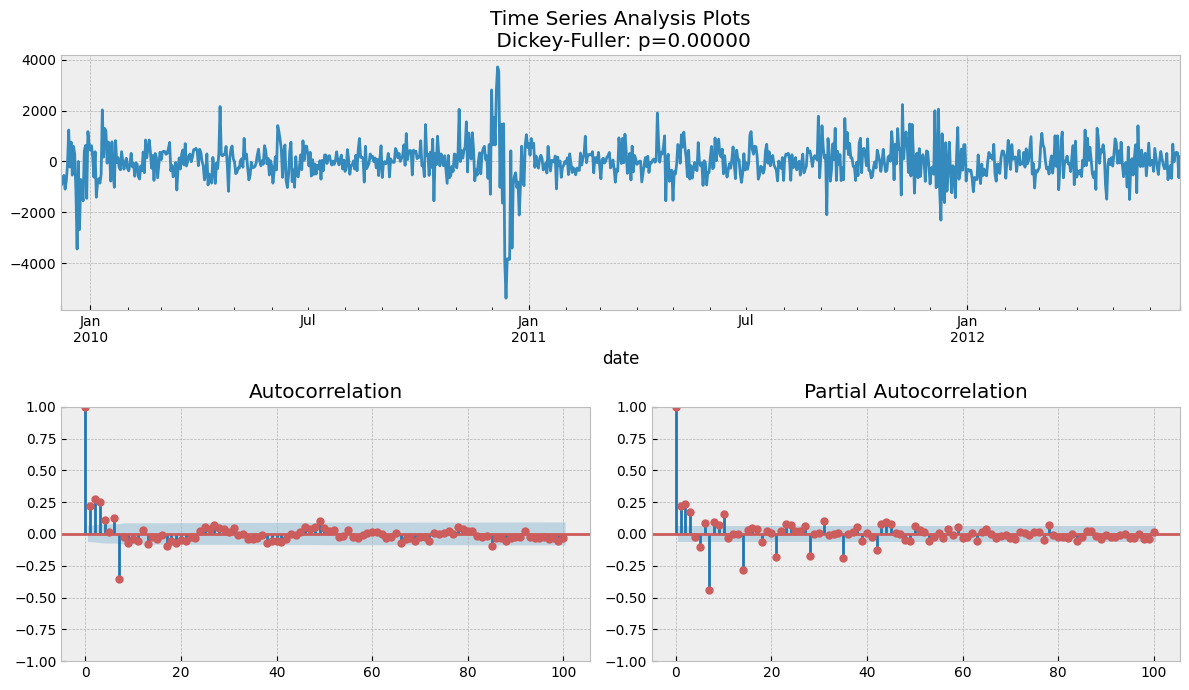

In [104]:
tsplot_new(retail_diff[7:], lags=100)

> P-значение стало нулевым — теперь все данные имеют высокое значение. Стационарность такого ряда подтверждена.

## Обучите модели ARIMA

- $p$ — 7 или 10 как лаги, после которых другие лаги незначительны;
- $d$ — 0 по числу несезонных различий;
- $q$ — 6-й или 7-й лаг на графике ACF;
- $P$ — 5 или 6 по числу лагов, которые имеют сезонную периодичность на графике PACF;
- $D$ — 1, поскольку взята сезонная разница;
- $Q$ — 1, так как только 7-й лаг по ACF значителен.

In [105]:
p = range(7, 11)
d = 0
q = range(6, 8)
P = range(5, 7)
D = 1
Q = range(0, 2)
s = 7 # сезонная длина

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

32

In [106]:
parameters_list

[(7, 6, 5, 0),
 (7, 6, 5, 1),
 (7, 6, 6, 0),
 (7, 6, 6, 1),
 (7, 7, 5, 0),
 (7, 7, 5, 1),
 (7, 7, 6, 0),
 (7, 7, 6, 1),
 (8, 6, 5, 0),
 (8, 6, 5, 1),
 (8, 6, 6, 0),
 (8, 6, 6, 1),
 (8, 7, 5, 0),
 (8, 7, 5, 1),
 (8, 7, 6, 0),
 (8, 7, 6, 1),
 (9, 6, 5, 0),
 (9, 6, 5, 1),
 (9, 6, 6, 0),
 (9, 6, 6, 1),
 (9, 7, 5, 0),
 (9, 7, 5, 1),
 (9, 7, 6, 0),
 (9, 7, 6, 1),
 (10, 6, 5, 0),
 (10, 6, 5, 1),
 (10, 6, 6, 0),
 (10, 6, 6, 1),
 (10, 7, 5, 0),
 (10, 7, 5, 1),
 (10, 7, 6, 0),
 (10, 7, 6, 1)]

In [107]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(train_split['total sales'], order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    #result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [108]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/32 [00:00<?, ?it/s]

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

> **ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements**

> Ошибка в функции: почему-то ни одна из комбинаций не проходит "*try: model*", поэтому *result_table* остаётся пустым.

# **Классическая модель**

## Добавление новых параметров

> Создание лагов

In [109]:
# Копия начального датафрейма
data = pd.DataFrame(retail['total sales'].copy())
data.columns = ["y"]

In [110]:
# Добавление лагов целевой переменной от 7 до 30
for i in range(7, 31):
    data["lag_{}".format(i)] = data.y.shift(i)

In [111]:
data.tail(4)

,y,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
date,,,,,,,,,,,,,,,,,,,,,
2012-12-05,4528.532962,3487.276109,4325.108507,3476.735964,2366.193547,3686.572502,2727.717296,3932.584726,3366.968032,3980.787518,...,2346.041073,3276.697284,3517.831924,3379.856826,2286.682317,3627.089617,2910.002881,2401.526875,3290.497361,3188.933932
2012-12-06,6125.495419,4151.401719,3487.276109,4325.108507,3476.735964,2366.193547,3686.572502,2727.717296,3932.584726,3366.968032,...,2959.781902,2346.041073,3276.697284,3517.831924,3379.856826,2286.682317,3627.089617,2910.002881,2401.526875,3290.497361
2012-12-07,3476.642731,3762.832455,4151.401719,3487.276109,4325.108507,3476.735964,2366.193547,3686.572502,2727.717296,3932.584726,...,3020.112892,2959.781902,2346.041073,3276.697284,3517.831924,3379.856826,2286.682317,3627.089617,2910.002881,2401.526875
2012-12-08,3107.121266,2022.708998,3762.832455,4151.401719,3487.276109,4325.108507,3476.735964,2366.193547,3686.572502,2727.717296,...,2091.958266,3020.112892,2959.781902,2346.041073,3276.697284,3517.831924,3379.856826,2286.682317,3627.089617,2910.002881


In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [113]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [114]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [115]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [116]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies

    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                                    cv=tscv,
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

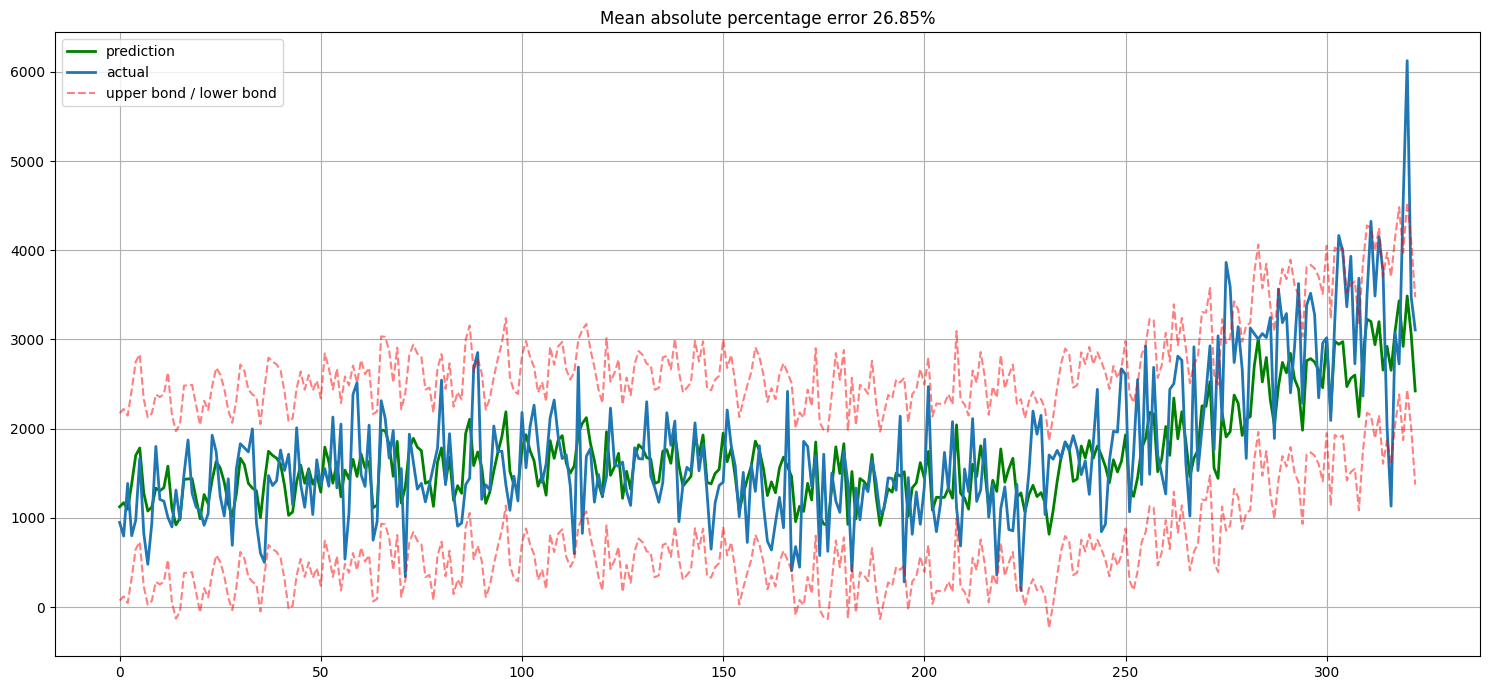

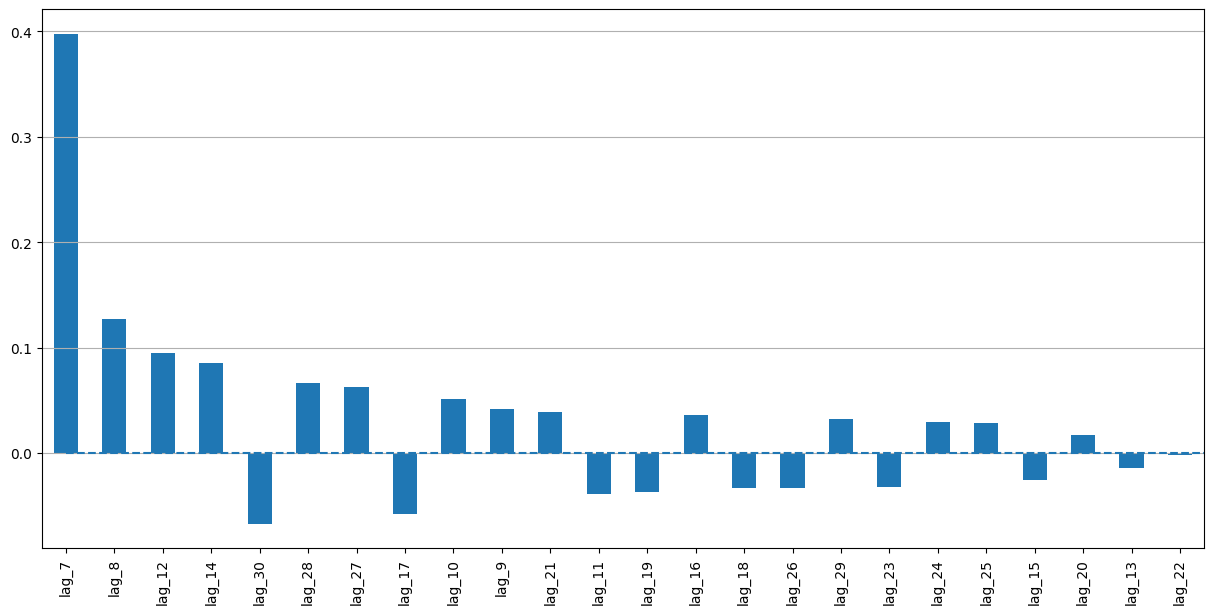

In [117]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)



---


> Добавление признаков из даты

> (Из-за большого количества данных график неказистый, но идея его проста: выделение данных по всем дням недели + отдельно выходных)

In [118]:
data.index = pd.to_datetime(data.index)
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2012-12-04,2726.403434,4325.108507,3476.735964,2366.193547,3686.572502,2727.717296,3932.584726,3366.968032,3980.787518,4165.619832,...,3379.856826,2286.682317,3627.089617,2910.002881,2401.526875,3290.497361,3188.933932,3564.651310,1,0
2012-12-05,4528.532962,3487.276109,4325.108507,3476.735964,2366.193547,3686.572502,2727.717296,3932.584726,3366.968032,3980.787518,...,3517.831924,3379.856826,2286.682317,3627.089617,2910.002881,2401.526875,3290.497361,3188.933932,2,0
2012-12-06,6125.495419,4151.401719,3487.276109,4325.108507,3476.735964,2366.193547,3686.572502,2727.717296,3932.584726,3366.968032,...,3276.697284,3517.831924,3379.856826,2286.682317,3627.089617,2910.002881,2401.526875,3290.497361,3,0
2012-12-07,3476.642731,3762.832455,4151.401719,3487.276109,4325.108507,3476.735964,2366.193547,3686.572502,2727.717296,3932.584726,...,2346.041073,3276.697284,3517.831924,3379.856826,2286.682317,3627.089617,2910.002881,2401.526875,4,0
2012-12-08,3107.121266,2022.708998,3762.832455,4151.401719,3487.276109,4325.108507,3476.735964,2366.193547,3686.572502,2727.717296,...,2959.781902,2346.041073,3276.697284,3517.831924,3379.856826,2286.682317,3627.089617,2910.002881,5,1


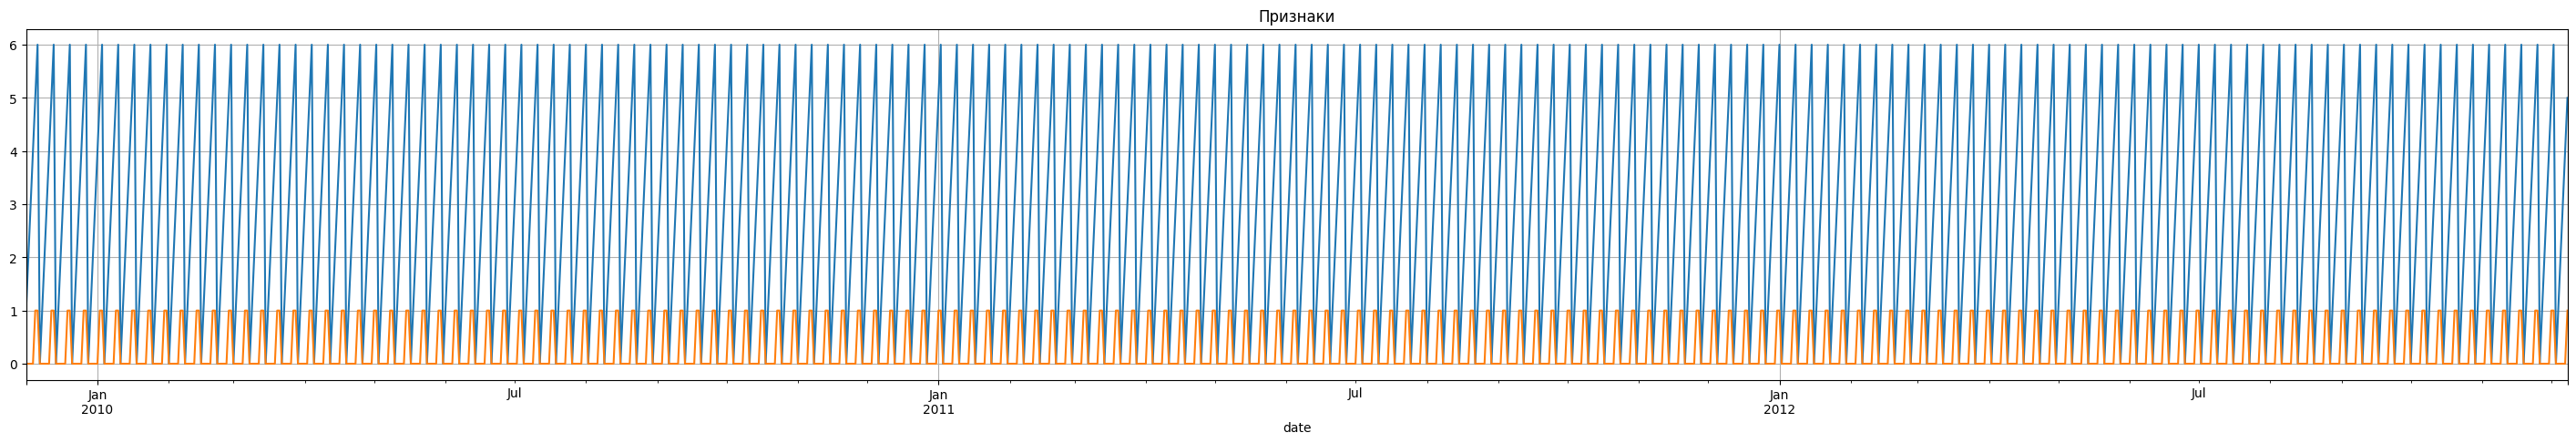

In [119]:
plt.figure(figsize=(36, 5))
plt.title("Признаки")
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

> Преобразование признаков в одну и ту же шкалу

In [120]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

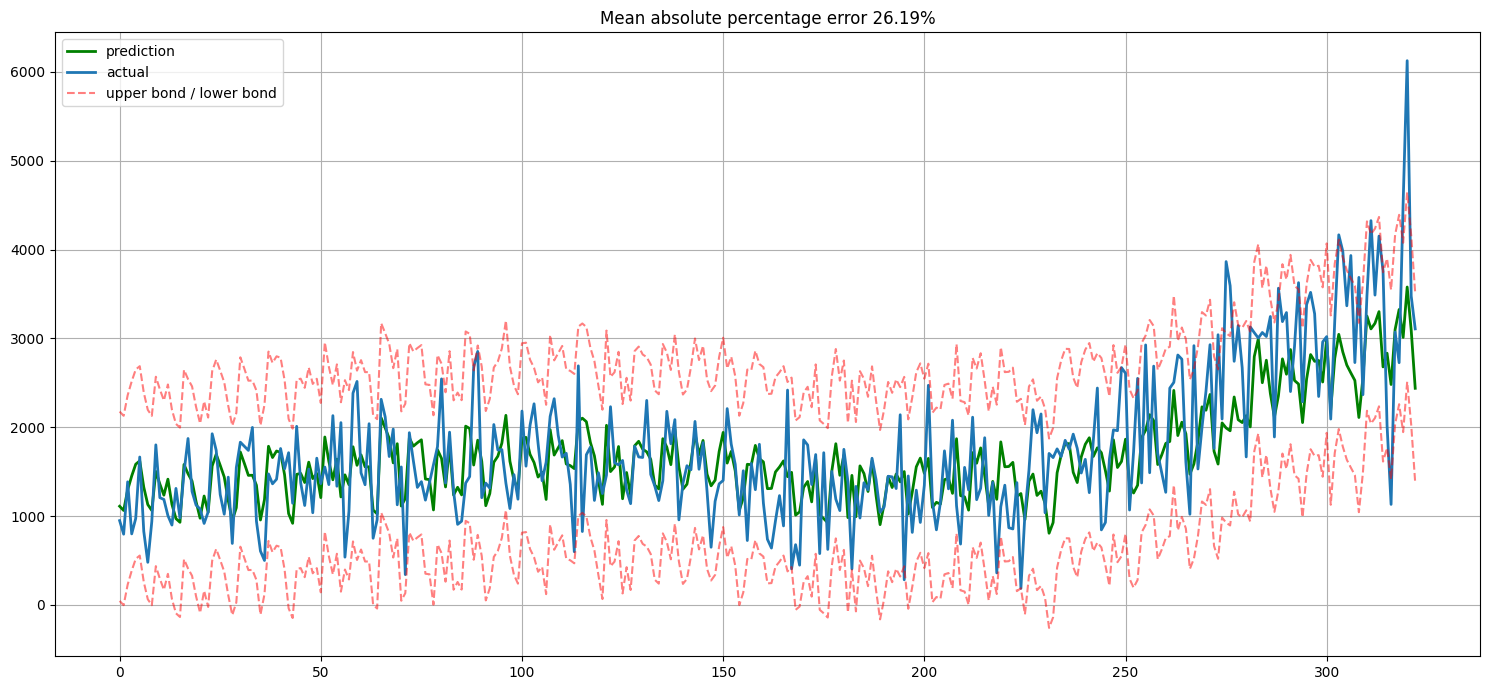

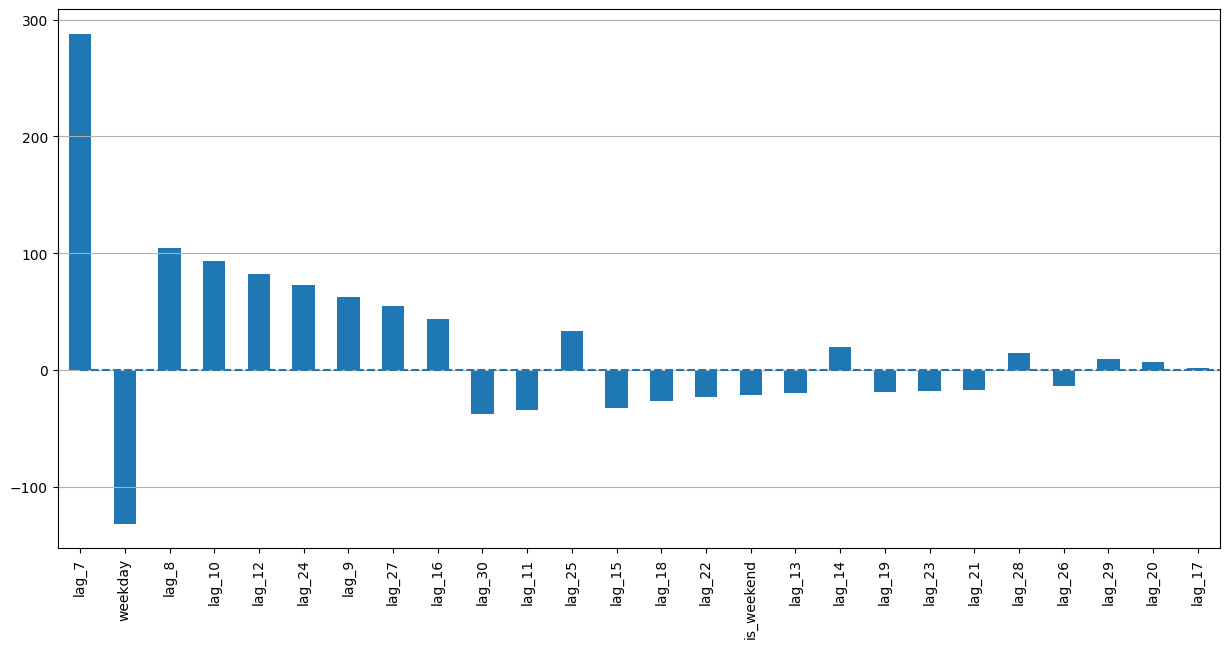

In [121]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)